In [1]:
# Set up feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.ethics.ex4 import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the data, separate features from target
data = pd.read_csv("../input/synthetic-credit-card-approval/synthetic_credit_card_approval.csv")
data.head()

,Num_Children,Group,Income,Own_Car,Own_Housing,Target
0,4,0,36151,0,0,0
1,0,0,36095,1,0,0
2,2,1,62110,1,1,0
3,0,1,73644,1,0,0
4,3,0,99146,0,0,1


In [97]:
data.shape

(500000, 6)

In [3]:
!pip install fairlearn --quiet
import fairlearn

In [31]:
# Get features into X and target into Y as label
X = data.drop(["Target"], axis=1)
y = data["Target"]

# Break into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [32]:
from fairlearn.preprocessing import CorrelationRemover

# Apply Correlation Remover on sensitive feature 'Group' for X_train
cr = CorrelationRemover(sensitive_feature_ids=['Group'])
dcr = cr.fit_transform(X_train)
dcr = pd.DataFrame(dcr, columns = ['Num_Children', 'Income', 'Own_Car', 'Own_Housing'])

In [33]:
# Add Group back into the features since CorrelationRemover drops the sensitive group
grp = X_train["Group"]
grp = grp.reset_index(drop = True)
dcr["Group"] = grp

In [34]:
np.isnan(dcr).value_counts()

Num_Children  Income  Own_Car  Own_Housing  Group
False         False   False    False        False    400000
dtype: int64

In [35]:
# Reorder columns
dcr = dcr[['Num_Children', 'Group', 'Income', 'Own_Car', 'Own_Housing']]

In [36]:
round(X_train.corr(), 5)

,Num_Children,Group,Income,Own_Car,Own_Housing
Num_Children,1.00000,-0.00020,-0.00192,0.00146,0.00056
Group,-0.00020,1.00000,0.32625,0.21804,0.20230
Income,-0.00192,0.32625,1.00000,0.06913,0.06348
Own_Car,0.00146,0.21804,0.06913,1.00000,0.04381
Own_Housing,0.00056,0.20230,0.06348,0.04381,1.00000


In [37]:
round(dcr.corr(), 5)

,Num_Children,Group,Income,Own_Car,Own_Housing
Num_Children,1.00000,-0.0,-0.00196,0.00154,0.00061
Group,-0.00000,1.0,-0.00000,-0.00000,0.00000
Income,-0.00196,-0.0,1.00000,-0.00217,-0.00272
Own_Car,0.00154,-0.0,-0.00217,1.00000,-0.00031
Own_Housing,0.00061,0.0,-0.00272,-0.00031,1.00000


In [38]:
# Check group balance
dcr["Group"].value_counts()

1    200295
0    199705
Name: Group, dtype: int64

In [39]:
# Repeat CorrelationRemover to X_test
dcr_test = cr.fit_transform(X_test)
dcr_test = pd.DataFrame(dcr_test, columns = ['Num_Children', 'Income', 'Own_Car', 'Own_Housing'])

tgrp = X_test["Group"]
tgrp = tgrp.reset_index(drop = True)
dcr_test["Group"] = tgrp

dcr_test = dcr_test[['Num_Children', 'Group', 'Income', 'Own_Car', 'Own_Housing']]

In [13]:
### In processing
from sklearn import metrics as skm
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from fairlearn.reductions import DemographicParity, ErrorRate, GridSearch
from fairlearn.metrics import (
    MetricFrame, selection_rate, count, selection_rate_difference
)

In [40]:
# dcr, dcr_test, y_train, y_test, sens = ['Group']
# unmitigated_predictor = LogisticRegression(solver="liblinear", fit_intercept=True)

# unmitigated_predictor.fit(dcr, y_train)

from sklearn import ensemble
unmitigated_predictor = ensemble.GradientBoostingClassifier(random_state=0)
unmitigated_predictor.fit(dcr, y_train)

GradientBoostingClassifier(random_state=0)

accuracy          0.97253
selection_rate    0.38677
count              100000
dtype: object
       accuracy selection_rate  count
Group                                
0      0.970762         0.1994  49970
1      0.974295       0.573916  50030


array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='Group'>],
       [<AxesSubplot:title={'center':'selection_rate'}, xlabel='Group'>],
       [<AxesSubplot:title={'center':'count'}, xlabel='Group'>]],
      dtype=object)

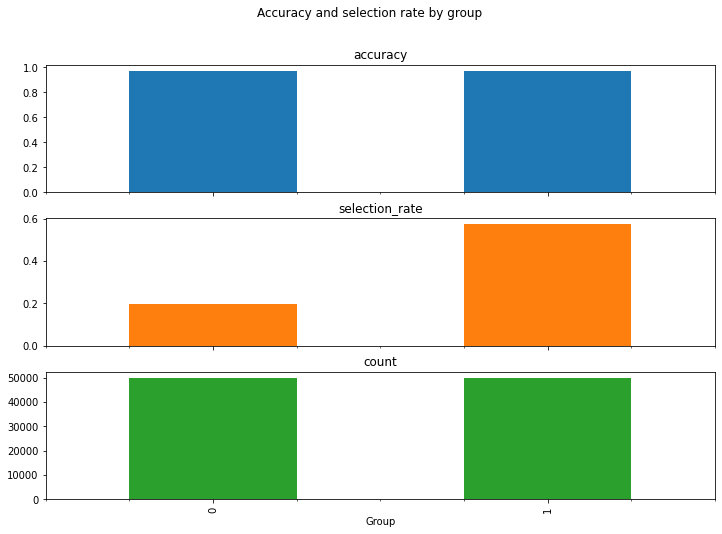

In [42]:
metric_frame = MetricFrame(
    metrics={
        "accuracy": skm.accuracy_score,
        "selection_rate": selection_rate,
        "count": count,
    },
    sensitive_features=dcr_test['Group'],
    y_true=y_test,
    y_pred=unmitigated_predictor.predict(dcr_test),
)
print(metric_frame.overall)
print(metric_frame.by_group)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 1],
    legend=False,
    figsize=[12, 8],
    title="Accuracy and selection rate by group",
)

In [43]:
sweep = GridSearch(
    ensemble.GradientBoostingClassifier(),
    constraints=DemographicParity(),
    grid_size=31,
)

In [44]:
sweep.fit(dcr, y_train, sensitive_features=dcr['Group'])
predictors = sweep.predictors_

/opt/conda/lib/python3.7/site-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
/opt/conda/lib/python3.7/site-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
/opt/conda/lib/python3.7/site-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use g

In [51]:
errors, disparities = [], []
for m in predictors:
    def classifier(X):
        return m.predict(X)

    error = ErrorRate()
    error.load_data(dcr, pd.Series(y_train), sensitive_features=dcr['Group'])
    disparity = DemographicParity()
    disparity.load_data(dcr, pd.Series(y_train), sensitive_features=dcr['Group'])

    errors.append(error.gamma(classifier)[0])
    disparities.append(disparity.gamma(classifier).max())

all_results = pd.DataFrame(
    {"predictor": predictors, "error": errors, "disparity": disparities}
)

non_dominated = []
for row in all_results.itertuples():
    errors_for_lower_or_eq_disparity = all_results["error"][
        all_results["disparity"] <= row.disparity
    ]
    if row.error <= errors_for_lower_or_eq_disparity.min():
        non_dominated.append(row.predictor)

Text(0, 0.5, 'selection rate difference')

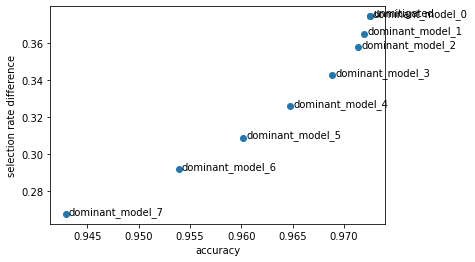

In [53]:
predictions = {"unmitigated": unmitigated_predictor.predict(dcr_test)}
metric_frames = {"unmitigated": metric_frame}
for i in range(len(non_dominated)):
    key = "dominant_model_{0}".format(i)
    predictions[key] = non_dominated[i].predict(dcr_test)

    metric_frames[key] = MetricFrame(
        metrics={
            "accuracy": skm.accuracy_score,
            "selection_rate": selection_rate,
            "count": count,
        },
        sensitive_features=dcr_test['Group'],
        y_true=y_test,
        y_pred=predictions[key],
    )

import matplotlib.pyplot as plt

x = [metric_frame.overall["accuracy"] for metric_frame in metric_frames.values()]
y = [
    metric_frame.difference()["selection_rate"]
    for metric_frame in metric_frames.values()
]
keys = list(metric_frames.keys())
plt.scatter(x, y)
for i in range(len(x)):
    plt.annotate(keys[i], (x[i] + 0.0003, y[i]))
plt.xlabel("accuracy")
plt.ylabel("selection rate difference")

In [89]:
redPreds = predictions['dominant_model_7']

In [90]:
# Function to plot confusion matrix
def plot_confusion_matrix(estimator, X, y_true, y_pred, display_labels=["Deny", "Approve"],
                          include_values=True, xticks_rotation='horizontal', values_format='',
                          normalize=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    return cm, disp.plot(include_values=include_values, cmap=cmap, xticks_rotation=xticks_rotation,
                     values_format=values_format)

Total approvals: 39183
Group A: 12886 (32.89% of approvals)
Group B: 26297 (67.11% of approvals)

Overall accuracy: 94.29%
Group A: 93.71%
Group B: 94.86%

Sensitivity / True positive rate:
Group A: 99.98%
Group B: 91.1%


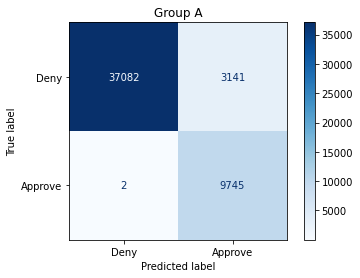

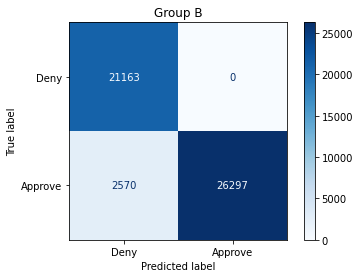

In [91]:
# Function to evaluate the fairness of the model
# Reset index to prevent error
def get_stats(X, y, model, group_one, preds):
    y = y.reset_index(drop = True)
    y_zero, preds_zero, X_zero = y[group_one==False], preds[group_one==False], X[group_one==False]
    y_one, preds_one, X_one = y[group_one], preds[group_one], X[group_one]
    
    print("Total approvals:", preds.sum())
    print("Group A:", preds_zero.sum(), "({}% of approvals)".format(round(preds_zero.sum()/sum(preds)*100, 2)))
    print("Group B:", preds_one.sum(), "({}% of approvals)".format(round(preds_one.sum()/sum(preds)*100, 2)))
    
    print("\nOverall accuracy: {}%".format(round((preds==y).sum()/len(y)*100, 2)))
    print("Group A: {}%".format(round((preds_zero==y_zero).sum()/len(y_zero)*100, 2)))
    print("Group B: {}%".format(round((preds_one==y_one).sum()/len(y_one)*100, 2)))
    
    cm_zero, disp_zero = plot_confusion_matrix(model, X_zero, y_zero, preds_zero)
    disp_zero.ax_.set_title("Group A")
    cm_one, disp_one = plot_confusion_matrix(model, X_one, y_one, preds_one)
    disp_one.ax_.set_title("Group B")
    
    print("\nSensitivity / True positive rate:")
    print("Group A: {}%".format(round(cm_zero[1,1] / cm_zero[1].sum()*100, 2)))
    print("Group B: {}%".format(round(cm_one[1,1] / cm_one[1].sum()*100, 2)))
    
# Evaluate the model    
get_stats(dcr_test, y_test, sweep, dcr_test["Group"]==1, redPreds)

In [92]:
sensitive_features = dcr["Group"]

from fairlearn.postprocessing import ThresholdOptimizer

postprocess_est = ThresholdOptimizer(
                    estimator=sweep,
                    constraints='demographic_parity',
                    objective='balanced_accuracy_score',
                    prefit=True,
                    predict_method = 'auto')
topt_model = postprocess_est.fit(dcr, y_train, sensitive_features=sensitive_features)
preds_topt = topt_model.predict(dcr_test, sensitive_features=dcr_test["Group"])

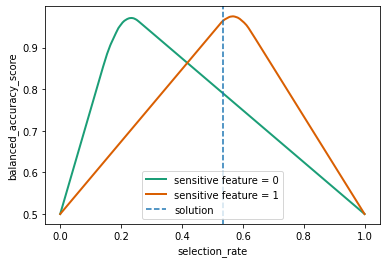

In [93]:
from fairlearn.postprocessing import plot_threshold_optimizer
plot_threshold_optimizer(postprocess_est)

Total approvals: 53316
Group A: 26538 (49.77% of approvals)
Group B: 26778 (50.23% of approvals)

Overall accuracy: 81.07%
Group A: 66.4%
Group B: 95.72%

Sensitivity / True positive rate:
Group A: 100.0%
Group B: 92.68%


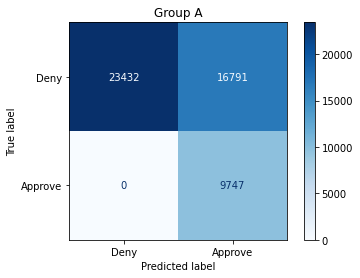

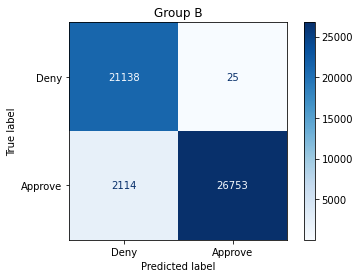

In [94]:
# accuracy score
get_stats(dcr_test, y_test, topt_model, dcr_test["Group"]==1, preds_topt)

Total approvals: 53316
Group A: 26538 (49.77% of approvals)
Group B: 26778 (50.23% of approvals)

Overall accuracy: 81.07%
Group A: 66.4%
Group B: 95.72%

Sensitivity / True positive rate:
Group A: 100.0%
Group B: 92.68%


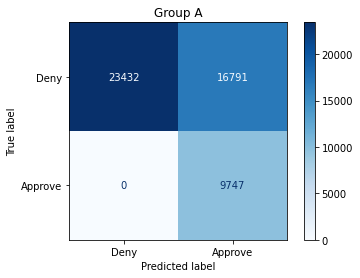

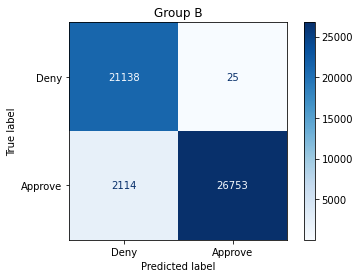

In [95]:
# balanced accuracy score
get_stats(dcr_test, y_test, topt_model, dcr_test["Group"]==1, preds_topt)

In [ ]:
# def visualize_model(model, feature_names, class_names=["Deny", "Approve"], impurity=False):
#     plot_list = tree.plot_tree(model, feature_names=feature_names, class_names=class_names, impurity=impurity)
#     [process_plot_item(item) for item in plot_list]

# def process_plot_item(item):
#     split_string = item.get_text().split("\n")
#     if split_string[0].startswith("samples"):
#         item.set_text(split_string[-1])
#     else:
#         item.set_text(split_string[0])

# plt.figure(figsize=(20, 6))
# plot_list = visualize_model(model_baseline, feature_names=dcr.columns)

In [ ]:
# ### Group Unaware, lets see how removing sensitive group completely performs
# dcr_train_unaware = dcr.drop(["Group"],axis=1)
# dcr_test_unaware = dcr_test.drop(["Group"],axis=1)

# # Train new model on new dataset
# model_unaware = ensemble.GradientBoostingClassifier(random_state=0)
# model_unaware.fit(dcr_train_unaware, y_train)

# # Evaluate the model
# preds_unaware = model_unaware.predict(dcr_test_unaware)
# get_stats(dcr_test_unaware, y_test, model_unaware, dcr_test["Group"]==1, preds_unaware)

In [ ]:
# sensitive_features = dcr["Group"]

# postprocess_est = ThresholdOptimizer(
#                     estimator=model_unaware,
#                     constraints='demographic_parity',
#                     objective='accuracy_score',
#                     prefit=True,
#                     predict_method = 'auto')
# topt_model = postprocess_est.fit(dcr_train_unaware, y_train, sensitive_features=sensitive_features)
# preds_topt = topt_model.predict(dcr_test_unaware, sensitive_features=dcr_test["Group"])

In [ ]:
# get_stats(dcr_test_unaware, y_test, topt_model, dcr_test["Group"]==1, preds_topt)

establish a disparity between groups, then focus on accuracy
concurrent accuracy/fairness evaluation
stick to one evaluation method
include evaluation step into report, how are we evaluating accuracy vs fairness